In [3]:
from data_utils import *
import cv2
import einops
import numpy as np
import torch
import random
import os


In [29]:
root_dir = "/data/om/reflection_anydoor/dataset/train"

masks_dir = f"{root_dir}/masks"
images_dir = f"{root_dir}/deformed"
image_name = "212_512x640.png"

ref_mask_path = os.path.join(masks_dir, image_name)
ref_image_path = os.path.join(images_dir, image_name)

ref_mask = cv2.imread(ref_mask_path)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2GRAY)

ref_image = cv2.imread(ref_image_path)

ref_mask = (ref_mask > 0).astype(np.uint8)
tar_mask = ref_mask.copy()
tar_image = ref_image.copy()


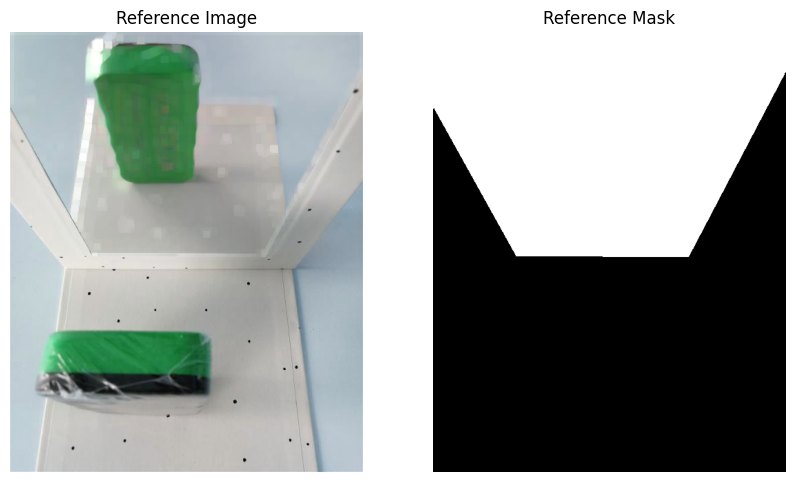

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(ref_image)
plt.title('Reference Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(ref_mask, cmap='gray')
plt.title('Reference Mask')
plt.axis('off')

plt.show()


In [30]:
ref_box_yyxx = get_bbox_from_mask(ref_mask)

# ref filter mask 
ref_mask_3 = np.stack([ref_mask,ref_mask,ref_mask],-1)
masked_ref_image = ref_image * ref_mask_3 + np.ones_like(ref_image) * 255 * (1-ref_mask_3)
reverse_masked_ref_image = ref_image * (1 - ref_mask_3) + np.ones_like(ref_image) * 255 * ref_mask_3

y1,y2,x1,x2 = ref_box_yyxx
masked_ref_image = masked_ref_image[y1:y2,x1:x2,:]
ref_mask = ref_mask[y1:y2,x1:x2]

ratio = np.random.randint(12, 13) / 10
masked_ref_image, ref_mask = expand_image_mask(masked_ref_image, ref_mask, ratio=ratio)
ref_mask_3 = np.stack([ref_mask,ref_mask,ref_mask],-1)
masked_ref_image = reverse_masked_ref_image

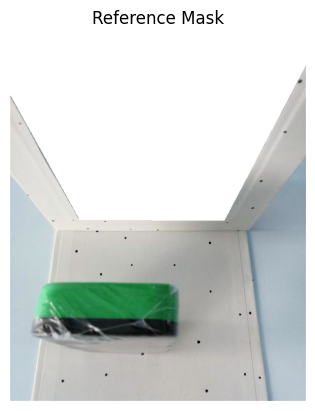

In [31]:
plt.imshow(reverse_masked_ref_image, cmap='gray')
plt.title('Reference Mask')
plt.axis('off')

plt.show()


In [32]:

# to square and resize
masked_ref_image = pad_to_square(masked_ref_image, pad_value = 255, random = False)
masked_ref_image = cv2.resize(masked_ref_image, (224,224) ).astype(np.uint8)

ref_mask_3 = pad_to_square(ref_mask_3 * 255, pad_value = 0, random = False)
ref_mask_3 = cv2.resize(ref_mask_3, (224,224) ).astype(np.uint8)
ref_mask = ref_mask_3[:,:,0]


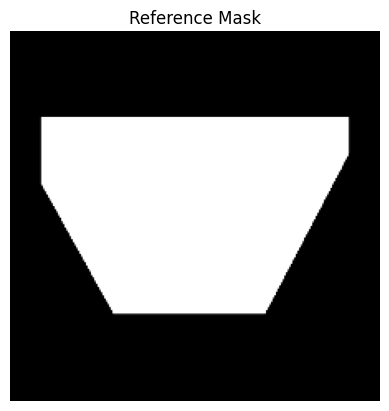

In [33]:
plt.imshow(ref_mask, cmap='gray')
plt.title('Reference Mask')
plt.axis('off')

plt.show()


In [34]:

# collage aug 
masked_ref_image_compose, ref_mask_compose = masked_ref_image, ref_mask #aug_data_mask(masked_ref_image, ref_mask) 
masked_ref_image_aug = masked_ref_image_compose.copy()
ref_mask_3 = np.stack([ref_mask_compose,ref_mask_compose,ref_mask_compose],-1)
ref_image_collage = sobel(masked_ref_image_compose, ref_mask_compose/255)
# removing the sobel features
ref_image_collage = np.zeros_like(masked_ref_image_compose)



(224, 224, 3)


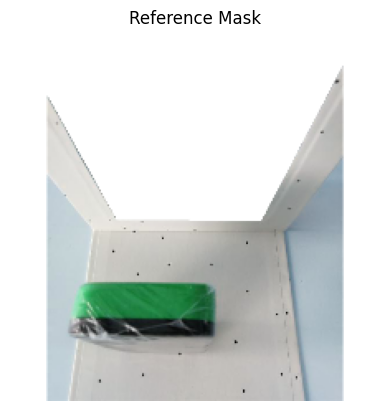

In [35]:
print(masked_ref_image_aug.shape)
plt.imshow(masked_ref_image_aug, cmap='gray')
plt.title('Reference Mask')
plt.axis('off')

plt.show()


In [37]:




# ========= Target ===========
tar_box_yyxx = get_bbox_from_mask(tar_mask)
tar_box_yyxx = expand_bbox(tar_mask, tar_box_yyxx, ratio=[1.1,1.2])

# crop
tar_box_yyxx_crop =  expand_bbox(tar_image, tar_box_yyxx, ratio=[1.5, 3])    #1.2 1.6
tar_box_yyxx_crop = box2squre(tar_image, tar_box_yyxx_crop) # crop box
y1,y2,x1,x2 = tar_box_yyxx_crop

cropped_target_image = tar_image[y1:y2,x1:x2,:]
tar_box_yyxx = box_in_box(tar_box_yyxx, tar_box_yyxx_crop)
y1,y2,x1,x2 = tar_box_yyxx

# collage
ref_image_collage = cv2.resize(ref_image_collage, (x2-x1, y2-y1))
ref_mask_compose = cv2.resize(ref_mask_compose.astype(np.uint8), (x2-x1, y2-y1))
ref_mask_compose = (ref_mask_compose > 128).astype(np.uint8)

collage = cropped_target_image.copy() 
collage[y1:y2,x1:x2,:] = ref_image_collage

collage_mask = cropped_target_image.copy() * 0.0
collage_mask[y1:y2,x1:x2,:] = 1.0
    
# the size before pad
H1, W1 = collage.shape[0], collage.shape[1]
cropped_target_image = pad_to_square(cropped_target_image, pad_value = 0, random = False).astype(np.uint8)
collage = pad_to_square(collage, pad_value = 0, random = False).astype(np.uint8)
collage_mask = pad_to_square(collage_mask, pad_value = -1, random = False).astype(np.uint8)

# the size after pad
H2, W2 = collage.shape[0], collage.shape[1]
cropped_target_image = cv2.resize(cropped_target_image, (512,512)).astype(np.float32)
collage = cv2.resize(collage, (512,512)).astype(np.float32)
collage_mask  = (cv2.resize(collage_mask, (512,512)).astype(np.float32) > 0.5).astype(np.float32)

cv2.imwrite('inf_image.png', ref_image)
cv2.imwrite('inf_ref.png', masked_ref_image_aug)
cv2.imwrite('inf_cropped_target.png', cropped_target_image)
cv2.imwrite('inf_hint.png', collage)

masked_ref_image_aug = masked_ref_image_aug  / 255 
cropped_target_image = cropped_target_image / 127.5 - 1.0
collage = collage / 127.5 - 1.0 
collage = np.concatenate([collage, collage_mask[:,:,:1]  ] , -1)
# collage = masked_ref_image_aug.copy()

item = dict(ref=masked_ref_image_aug.copy(), jpg=cropped_target_image.copy(), hint=collage.copy(), extra_sizes=np.array([H1, W1, H2, W2]), tar_box_yyxx_crop=np.array( tar_box_yyxx_crop ) ) 
# return item


In [62]:
cropped_target_image.shape

(512, 512, 3)

In [61]:
print(collage.shape)

(512, 512, 4)


In [43]:
root_dir = "/data/om/reflection_anydoor/dataset/train"

masks_dir = f"{root_dir}/masks"
images_dir = f"{root_dir}/deformed"
image_name = "212_512x640.png"

ref_mask_path = os.path.join(masks_dir, image_name)
ref_image_path = os.path.join(images_dir, image_name)

ref_mask = cv2.imread(ref_mask_path)
ref_mask = cv2.cvtColor(ref_mask, cv2.COLOR_BGR2GRAY)

ref_image = cv2.imread(ref_image_path)

ref_mask = (ref_mask > 0).astype(np.uint8)
tar_mask = ref_mask.copy()
tar_image = ref_image.copy()


In [57]:
def mask_img(image, mask):
  # Invert the mask to get the region to be preserved.
  ref_mask_3 = np.stack([ref_mask,ref_mask,ref_mask],-1)
  masked_ref_image = ref_image * ref_mask_3 + np.ones_like(ref_image) * 255 * (1-ref_mask_3)

  return masked_ref_image

def rev_mask_img(image, mask):
  # Invert the mask to get the region to be preserved.
  ref_mask_3 = np.stack([ref_mask,ref_mask,ref_mask],-1)
  reverse_masked_ref_image = ref_image * (1 - ref_mask_3) + np.ones_like(ref_image) * 255 * ref_mask_3

  return reverse_masked_ref_image

In [63]:
reverse_img = rev_mask_img(ref_image, ref_mask)

(224, 224, 3)


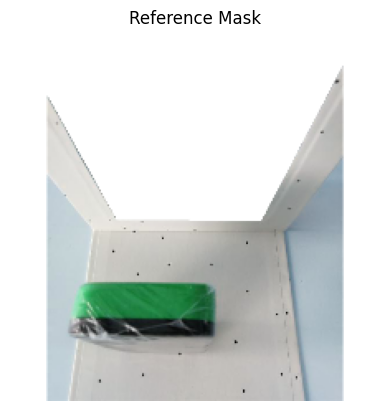

In [60]:
print(reverse_img.shape)
plt.imshow(reverse_img, cmap='gray')
plt.title('Reference Mask')
plt.axis('off')
plt.show()

In [59]:
reverse_img = pad_to_square(reverse_img, pad_value = 255, random = False)
reverse_img = cv2.resize(reverse_img, (224,224) ).astype(np.uint8)